In [6]:
!ls /kaggle/input

handwriting-recognition  handwritten-characters


In [7]:
!pip install imutils



You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [9]:
import numpy as np
import pandas as pd
import os
import cv2
import imutils
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Reshape, LSTM, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils
from keras import optimizers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns





In [10]:

img_size = 64  


train_data = []
val_data = []


non_chars = ["#", "$", "&", "@"]


def load_data(dir, data_list, max_samples=4000):
    for label in os.listdir(dir):
        if label in non_chars:
            continue
        count = 0
        sub_directory = os.path.join(dir, label)
        for file in os.listdir(sub_directory):
            if count >= max_samples:
                break
            img = cv2.imread(os.path.join(sub_directory, file), 0)
            img = cv2.resize(img, (img_size, img_size))
            data_list.append([img, label])
            count += 1


load_data("/kaggle/input/handwritten-characters/Train", train_data)
load_data("/kaggle/input/handwritten-characters/Validation", val_data, max_samples=1000)

In [11]:
len(train_data)

140000

In [12]:
len(val_data)

15209

In [13]:
random.shuffle(train_data)
random.shuffle(val_data)

In [14]:
train_X, train_Y = zip(*train_data)
val_X, val_Y = zip(*val_data)

In [15]:
lb = LabelBinarizer()
train_Y = lb.fit_transform(train_Y)
val_Y = lb.transform(val_Y)

In [16]:
train_X = np.array(train_X) / 255.0
val_X = np.array(val_X) / 255.0
train_X = train_X.reshape(-1, img_size, img_size, 1) 
val_X = val_X.reshape(-1, img_size, img_size, 1)

print("Training data shape:", train_X.shape)
print("Validation data shape:", val_X.shape)

Training data shape: (140000, 64, 64, 1)
Validation data shape: (15209, 64, 64, 1)


In [17]:
print(train_Y.shape,val_Y.shape)

(140000, 35) (15209, 35)


In [68]:
model = Sequential()

# CNN Layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())

# Reshape the data for the LSTM layer
model.add(Reshape((256, -1)))

# RNN Layers
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))

# Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(lb.classes_), activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

In [69]:

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 12, 128)      

In [92]:
history = model.fit(train_X, train_Y, epochs=2, batch_size=32, validation_data=(val_X, val_Y), verbose=1)


Epoch 1/2
4375/4375 [==============================] - 243s 55ms/step - loss: 0.2397 - accuracy: 0.9162 - val_loss: 0.2564 - val_accuracy: 0.9087
Epoch 2/2
4375/4375 [==============================] - 242s 55ms/step - loss: 0.2303 - accuracy: 0.9190 - val_loss: 0.2571 - val_accuracy: 0.9128


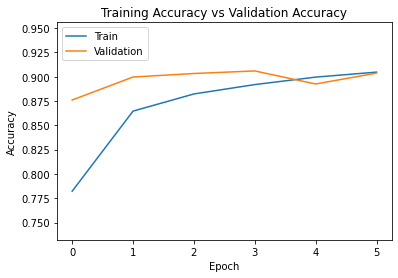

In [71]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Set y-axis limits
min_accuracy = min(min(history.history['accuracy']), min(history.history['val_accuracy']))
max_accuracy = max(max(history.history['accuracy']), max(history.history['val_accuracy']))
plt.ylim(min_accuracy - 0.05, max_accuracy + 0.05)  # Adjust the range for better visibility

plt.show()


In [93]:
print("The validation accuracy is: {:.2f}%".format(history.history['val_accuracy'][-1] * 100))
print("The training accuracy is: {:.2f}%".format(history.history['accuracy'][-1] * 100))
print("The validation loss is: {:.4f}".format(history.history['val_loss'][-1]))
print("The training loss is: {:.4f}".format(history.history['loss'][-1]))

The validation accuracy is: 91.28%
The training accuracy is: 91.90%
The validation loss is: 0.2571
The training loss is: 0.2303


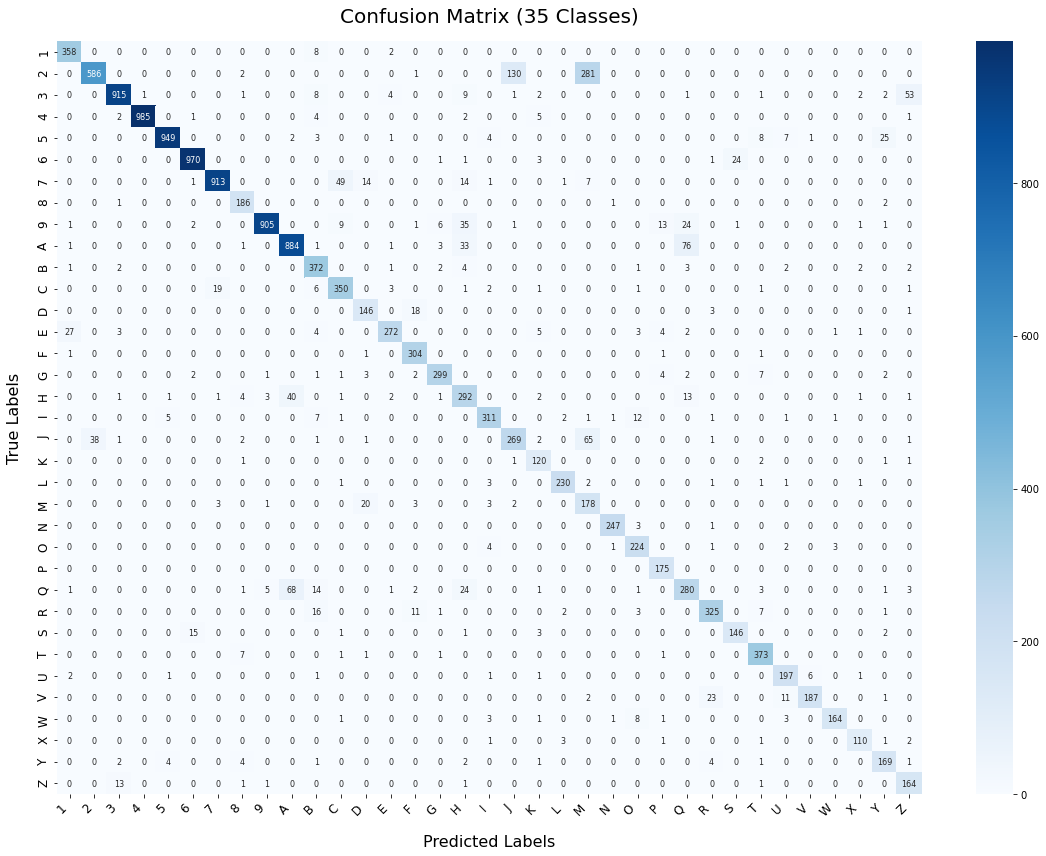

              precision    recall  f1-score   support

           1       0.91      0.97      0.94       368
           2       0.94      0.59      0.72      1000
           3       0.97      0.92      0.94      1000
           4       1.00      0.98      0.99      1000
           5       0.99      0.95      0.97      1000
           6       0.98      0.97      0.97      1000
           7       0.98      0.91      0.94      1000
           8       0.89      0.98      0.93       190
           9       0.99      0.91      0.94      1000
           A       0.89      0.88      0.89      1000
           B       0.83      0.95      0.89       392
           C       0.84      0.91      0.88       385
           D       0.78      0.87      0.82       168
           E       0.95      0.84      0.89       322
           F       0.89      0.99      0.94       308
           G       0.95      0.92      0.94       324
           H       0.70      0.80      0.75       363
           I       0.93    

In [100]:

# Make Predictions on Validation Data
y_val_pred = model.predict(val_X)  # Predicted probabilities for each class
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert probabilities to class labels
y_val_true = np.argmax(val_Y, axis=1)  # Convert one-hot encoded true labels to class indices

# Define Class Labels for 35 classes
class_labels_35 = (
    [str(i) for i in range(1, 10)] +   # Digits 1-9
    [chr(i) for i in range(65, 91)]    # Uppercase letters A-Z
)

# Ensure the labels match the unique classes
assert len(class_labels_35) == 35, "The number of class labels does not match the number of classes."

# Compute the Confusion Matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

# Plot the Confusion Matrix
plt.figure(figsize=(16, 12))  # Increase figure size for readability
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels_35, yticklabels=class_labels_35, cbar=True, annot_kws={"size": 8})
plt.title('Confusion Matrix (35 Classes)', fontsize=20, pad=20)  # Add padding to title
plt.xlabel('Predicted Labels', fontsize=16, labelpad=15)  # Add padding to x-axis label
plt.ylabel('True Labels', fontsize=16, labelpad=15)  # Add padding to y-axis label
plt.xticks(fontsize=12, rotation=45, ha='right')  # Rotate and align x-axis labels
plt.yticks(fontsize=12)
plt.tight_layout()  # Ensure layout does not crop labels
plt.show()

# Print Classification Report
print(classification_report(
    y_val_true, y_val_pred_classes, 
    target_names=class_labels_35
))


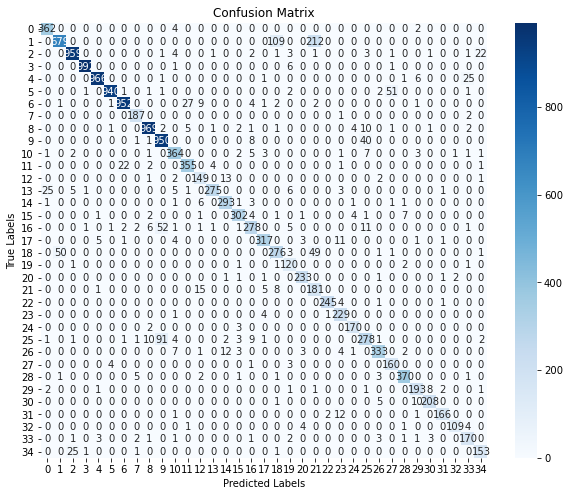

Accuracy: 0.912814780721941
Precision: 0.9229436636277139
Recall: 0.912814780721941
F1 Score: 0.9145989142890659


In [94]:
# Step 1: Make Predictions on Validation Data
y_val_pred = model.predict(val_X)  # Get predicted probabilities
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert probabilities to class labels
y_val_true = np.argmax(val_Y, axis=1)  # Convert one-hot encoded true labels to class labels

# Compute the Confusion Matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
class_labels = [str(i) for i in range(conf_matrix.shape[0])]  # Adjust class labels as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Compute Metrics
accuracy = accuracy_score(y_val_true, y_val_pred_classes)
precision = precision_score(y_val_true, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true, y_val_pred_classes, average='weighted')

# Print Metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# # Print Classification Report
# print(classification_report(y_val_true, y_val_pred_classes))


In [29]:
import numpy as np

# Check unique true labels
unique_true_labels = np.unique(y_val_true)
print("Unique true labels:", unique_true_labels)
print("Number of unique true labels:", len(unique_true_labels))


Unique true labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
Number of unique true labels: 35


In [30]:
train = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_train_v2.csv')
valid = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_validation_v2.csv')
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

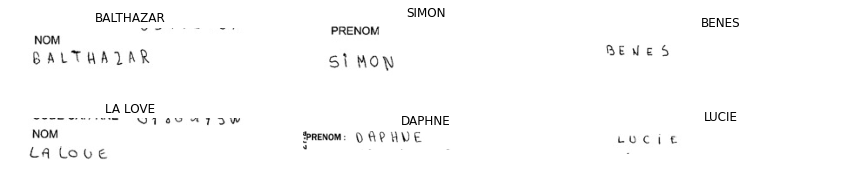

In [31]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

Predicted Character: F


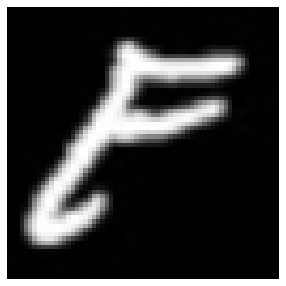

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_character(img_path, model, lb):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Preprocess the image
    image = cv2.resize(image, (64, 64))  # Resize to 64x64
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=-1)
    image = image.reshape(1, 64, 64, 1)
    
    # Predict the character
    ypred = model.predict(image)
    ypred = lb.inverse_transform(ypred)
    [predicted_char] = ypred
    
    return predicted_char, image  # Return the image as well

char_image_path = "/kaggle/input/handwritten-characters/Train/E/1001.jpg"

predicted_character, single_image = predict_character(char_image_path, model, lb)

print("Predicted Character:", predicted_character)

# Display the image
plt.figure(figsize=(5,5)) 
plt.imshow(single_image.squeeze(), cmap='gray')  # Use squeeze to remove the single-dimensional entry
plt.axis('off') 

plt.show()


In [33]:


def get_letters_and_predict(img_path, model, lb):
    letters = []
    image = cv2.imread(img_path)
    image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    # Sort contours with lambda for left-to-right sorting
    cnts = sorted(cnts, key=lambda c: cv2.boundingRect(c)[0])
    
    for c in cnts:
        if cv2.contourArea(c) > 10:
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)  
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            thresh = cv2.resize(thresh, (64, 64), interpolation=cv2.INTER_CUBIC).astype("float32") / 255.0
            thresh = np.expand_dims(thresh, axis=-1).reshape(1, 64, 64, 1)
            
            # Predict and convert result to label
            ypred_label = np.argmax(model.predict(thresh), axis=-1)
            ypred_char = lb.classes_[ypred_label][0]
            letters.append(ypred_char)

    return "".join(letters), image





Recognized Word: LILQU


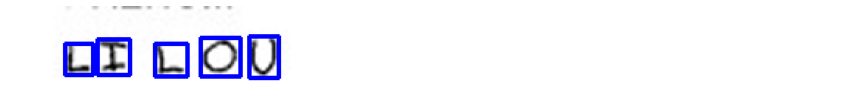

In [34]:
test_image_path = "/kaggle/input/handwriting-recognition/train_v2/train/TRAIN_00023.jpg"
recognized_text, processed_image = get_letters_and_predict(test_image_path, model, lb)

print("Recognized Word:", recognized_text)
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Predicted Words: ['LILQU', 'JAFFFUX']
True Characters: ['L', 'I', 'L', 'O', 'U', 'J', 'A', 'F', 'F', 'E', 'U', 'X']
Predicted Characters: ['L', 'I', 'L', 'Q', 'U', 'J', 'A', 'F', 'F', 'F', 'U', 'X']


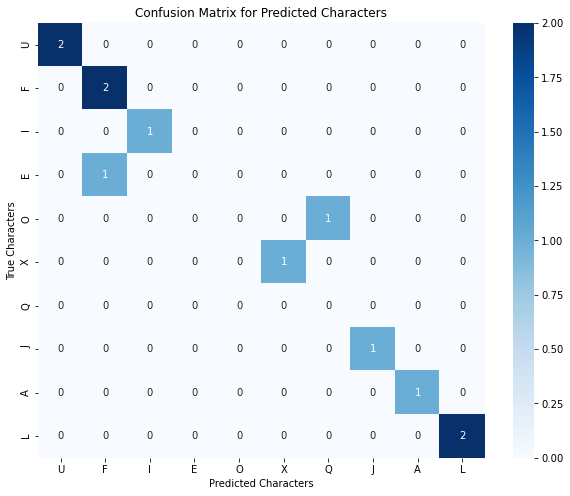

Confusion Matrix for Predicted Characters:
[[2 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 2]]


In [35]:


test_image_paths = ["/kaggle/input/handwriting-recognition/train_v2/train/TRAIN_00023.jpg", 
                    "/kaggle/input/handwriting-recognition/train_v2/train/TRAIN_00030.jpg"]  
true_words = ['LILOU', 'JAFFEUX']

# Predict words for the given test image paths
predicted_words = []

for img_path, true_word in zip(test_image_paths, true_words):
    predicted_word, _ = get_letters_and_predict(img_path, model, lb)
    predicted_words.append(predicted_word)

print("Predicted Words:", predicted_words)

# Step 1: Flatten words into characters
true_characters = [char for word in true_words for char in word]
predicted_characters = [char for word in predicted_words for char in word]

print("True Characters:", true_characters)
print("Predicted Characters:", predicted_characters)


all_labels = set(true_characters).union(set(predicted_characters))

# Step 2: Generate confusion matrix using the combined set of characters
cm = confusion_matrix(true_characters, predicted_characters, labels=list(all_labels))

# Step 3: Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(all_labels), yticklabels=list(all_labels))
plt.xlabel('Predicted Characters')
plt.ylabel('True Characters')
plt.title('Confusion Matrix for Predicted Characters')
plt.show()

# Optionally, print the confusion matrix values
print("Confusion Matrix for Predicted Characters:")
print(cm)


In [101]:
# Define the CNN model
cnn_model = Sequential()

# Add convolutional and pooling layers
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

# Add fully connected layers
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(len(lb.classes_), activation='softmax'))

# Compile the model
cnn_model.compile(
    loss='categorical_crossentropy', 
    optimizer="adam", 
    metrics=['accuracy']
)


In [102]:
# Assuming you have training data loaded in train_X and train_Y
history = cnn_model.fit(train_X, train_Y, epochs=3, batch_size=32, validation_data=(val_X, val_Y))


Epoch 1/3
4375/4375 [==============================] - 19s 4ms/step - loss: 0.5630 - accuracy: 0.8215 - val_loss: 0.3194 - val_accuracy: 0.8966
Epoch 2/3
4375/4375 [==============================] - 18s 4ms/step - loss: 0.3328 - accuracy: 0.8882 - val_loss: 0.2808 - val_accuracy: 0.8908
Epoch 3/3
4375/4375 [==============================] - 18s 4ms/step - loss: 0.2843 - accuracy: 0.9038 - val_loss: 0.2682 - val_accuracy: 0.9049


Predicted Words: ['LILQU', 'JAFFEUX']
True Characters: ['L', 'I', 'L', 'O', 'U', 'J', 'A', 'F', 'F', 'E', 'U', 'X']
Predicted Characters: ['L', 'I', 'L', 'Q', 'U', 'J', 'A', 'F', 'F', 'E', 'U', 'X']


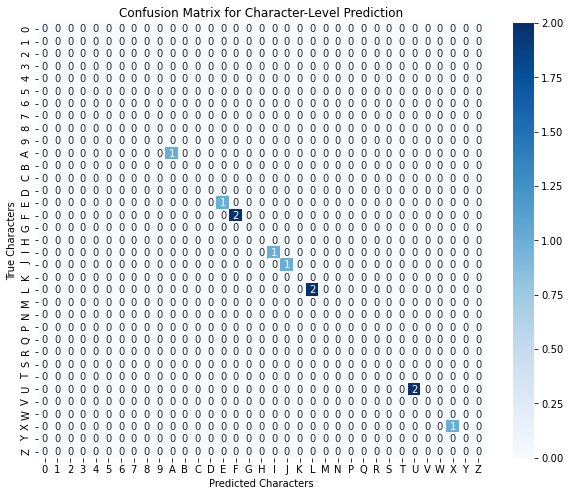

In [41]:

test_image_paths = ["/kaggle/input/handwriting-recognition/train_v2/train/TRAIN_00023.jpg", 
                    "/kaggle/input/handwriting-recognition/train_v2/train/TRAIN_00030.jpg"]  # Replace with actual paths
true_words = ['LILOU', 'JAFFEUX']

# Predict words for the given test image paths
predicted_words = []

for img_path, true_word in zip(test_image_paths, true_words):
    predicted_word, _ = get_letters_and_predict(img_path,cnn_model, lb)
    predicted_words.append(predicted_word)

print("Predicted Words:", predicted_words)

# Step 1: Flatten words into characters
true_characters = [char for word in true_words for char in word]
predicted_characters = [char for word in predicted_words for char in word]

print("True Characters:", true_characters)
print("Predicted Characters:", predicted_characters)

# Ensure that the true and predicted character lists are of the same length
assert len(true_characters) == len(predicted_characters), "Mismatch in character lengths!"

# Step 2: Generate confusion matrix
cm = confusion_matrix(true_characters, predicted_characters, labels=lb.classes_)

# Step 3: Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel('Predicted Characters')
plt.ylabel('True Characters')
plt.title('Confusion Matrix for Character-Level Prediction')
plt.show()


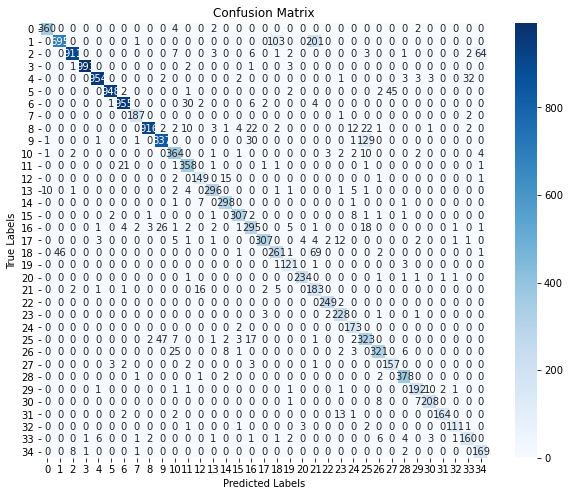

Accuracy: 0.9048589650864619
Precision: 0.9191737038696941
Recall: 0.9048589650864619
F1 Score: 0.9083470032161156


In [103]:
# Step 1: Make Predictions on Validation Data
y_val_pred = cnn_model.predict(val_X)  # Get predicted probabilities
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert probabilities to class labels
y_val_true = np.argmax(val_Y, axis=1)  # Convert one-hot encoded true labels to class labels

# Compute the Confusion Matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
class_labels = [str(i) for i in range(conf_matrix.shape[0])]  # Adjust class labels as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Compute Metrics
accuracy = accuracy_score(y_val_true, y_val_pred_classes)
precision = precision_score(y_val_true, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true, y_val_pred_classes, average='weighted')

# Print Metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# # Print Classification Report
# print(classification_report(y_val_true, y_val_pred_classes))


In [95]:


# Build the RNN model (LSTM)
model_rnn = Sequential()

# Reshape the input data for RNN
model_rnn.add(Reshape((256, -1), input_shape=(img_size, img_size, 1)))

# Add LSTM layers
model_rnn.add(LSTM(128, return_sequences=True))
model_rnn.add(Dropout(0.3))
model_rnn.add(LSTM(64))

# Fully connected layer
model_rnn.add(Dense(128, activation='relu'))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(len(lb.classes_), activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_rnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)



In [ ]:
# Train the RNN model
history_rnn = model_rnn.fit(train_X, train_Y, epochs=3, batch_size=32, validation_data=(val_X, val_Y), callbacks=[reduce_lr], verbose=1)


Predicted Words: ['DIDBQ', 'ZGZFZQK']
True Characters: ['L', 'I', 'L', 'O', 'U', 'J', 'A', 'F', 'F', 'E', 'U', 'X']
Predicted Characters: ['D', 'I', 'D', 'B', 'Q', 'Z', 'G', 'Z', 'F', 'Z', 'Q', 'K']


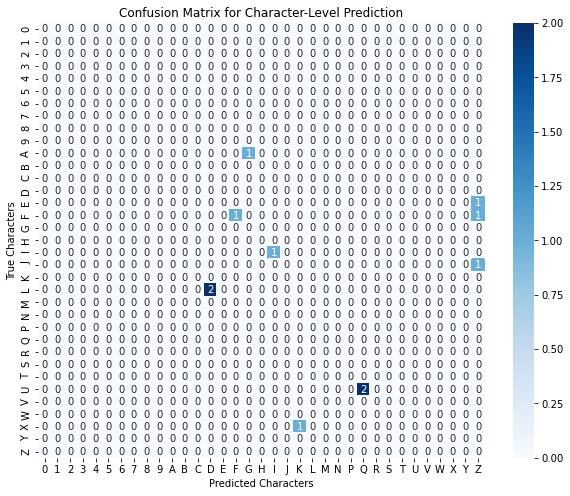

In [45]:

test_image_paths = ["/kaggle/input/handwriting-recognition/train_v2/train/TRAIN_00023.jpg", 
                    "/kaggle/input/handwriting-recognition/train_v2/train/TRAIN_00030.jpg"]  # Replace with actual paths
true_words = ['LILOU', 'JAFFEUX']

# Predict words for the given test image paths
predicted_words = []

for img_path, true_word in zip(test_image_paths, true_words):
    predicted_word, _ = get_letters_and_predict(img_path, model_rnn, lb)
    predicted_words.append(predicted_word)

print("Predicted Words:", predicted_words)

# Step 1: Flatten words into characters
true_characters = [char for word in true_words for char in word]
predicted_characters = [char for word in predicted_words for char in word]

print("True Characters:", true_characters)
print("Predicted Characters:", predicted_characters)

# Ensure that the true and predicted character lists are of the same length
assert len(true_characters) == len(predicted_characters), "Mismatch in character lengths!"

# Step 2: Generate confusion matrix
cm = confusion_matrix(true_characters, predicted_characters, labels=lb.classes_)

# Step 3: Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel('Predicted Characters')
plt.ylabel('True Characters')
plt.title('Confusion Matrix for Character-Level Prediction')
plt.show()


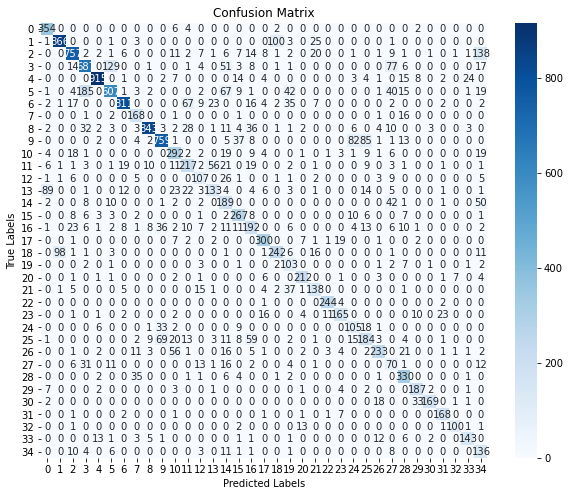

Accuracy: 0.7490959300414228
Precision: 0.7736307315826956
Recall: 0.7490959300414228
F1 Score: 0.7554623940717758


In [46]:
# Step 1: Make Predictions on Validation Data
y_val_pred = model_rnn.predict(val_X)  # Get predicted probabilities
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert probabilities to class labels
y_val_true = np.argmax(val_Y, axis=1)  # Convert one-hot encoded true labels to class labels

# Compute the Confusion Matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
class_labels = [str(i) for i in range(conf_matrix.shape[0])]  # Adjust class labels as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Compute Metrics
accuracy = accuracy_score(y_val_true, y_val_pred_classes)
precision = precision_score(y_val_true, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true, y_val_pred_classes, average='weighted')

# Print Metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# # Print Classification Report
print(classification_report(y_val_true, y_val_pred_classes))


In [47]:


# Flatten the image data for KNN
train_X_flat = train_X.reshape(train_X.shape[0], -1)
val_X_flat = val_X.reshape(val_X.shape[0], -1)

# Apply PCA to reduce dimensionality (optional but can help KNN)
pca = PCA(n_components=100)  # You can change n_components based on your requirement
train_X_pca = pca.fit_transform(train_X_flat)
val_X_pca = pca.transform(val_X_flat)

# Initialize KNN model
knn = KNeighborsClassifier(n_neighbors=3)






In [53]:
# Train the KNN model
knn.fit(train_X_pca, np.argmax(train_Y, axis=1))

KNeighborsClassifier(n_neighbors=3)

In [55]:
# Predict and evaluate the model
val_predictions = knn.predict(val_X_pca)
val_accuracy_knn = accuracy_score(np.argmax(val_Y, axis=1), val_predictions)

# Print the accuracy
print(f"KNN Model Validation Accuracy: {val_accuracy_knn * 100:.2f}%")

KNN Model Validation Accuracy: 85.88%


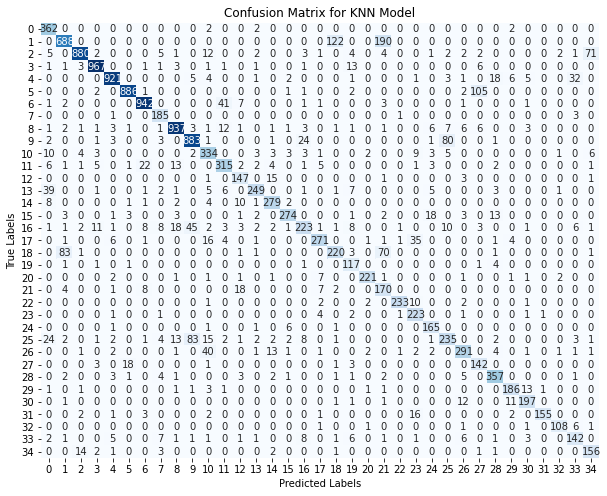

Confusion Matrix:
[[362   0   0 ...   0   0   0]
 [  0 688   0 ...   0   0   0]
 [  5   0 880 ...   2   1  71]
 ...
 [  0   0   0 ... 108   6   1]
 [  2   1   0 ...   0 142   0]
 [  0   0  14 ...   0   0 156]]


In [56]:
cm = confusion_matrix(np.argmax(val_Y, axis=1), val_predictions)

# Step 2: Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for KNN Model')
plt.show()

# Optionally, print the confusion matrix
print("Confusion Matrix:")
print(cm)

In [60]:

# True labels
y_val_true = np.argmax(val_Y, axis=1)

# Calculate Metrics
accuracy = accuracy_score(y_val_true, val_predictions)
precision = precision_score(y_val_true, val_predictions, average='weighted')
recall = recall_score(y_val_true, val_predictions, average='weighted')
f1 = f1_score(y_val_true, val_predictions, average='weighted')

# Print Metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print Classification Report
print(classification_report(y_val_true, val_predictions))




Accuracy: 0.8587678348346374
Precision: 0.872617791586454
Recall: 0.8587678348346374
F1 Score: 0.8613394867617149
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       368
           1       0.87      0.69      0.77      1000
           2       0.97      0.88      0.92      1000
           3       0.97      0.97      0.97      1000
           4       0.96      0.92      0.94      1000
           5       0.97      0.89      0.93      1000
           6       0.95      0.94      0.95      1000
           7       0.83      0.97      0.89       190
           8       0.94      0.94      0.94      1000
           9       0.86      0.88      0.87      1000
          10       0.75      0.85      0.80       392
          11       0.82      0.82      0.82       385
          12       0.75      0.88      0.81       168
          13       0.92      0.77      0.84       322
          14       0.86      0.91      0.88       308
          15       0.

## Drawbacks
1. The recognition part is dependent on the contour detection code, so if the opencv library is not able to find the character contour, then this method will fail.
2. There could be a lot of variation in a single handwritten letter in terms of writing style, therefore a lot more examples are needed for training this model.
3. This model will not work for connected texts like a cursive handwritten word.

## Conclusion 
This notebook is an illustration of how a character segmentation and classification approach can be used for offline handwritten text extraction. In order to improve the model, the model should be trained on the complete dataset, this notebook was trained on slightly less number of images due to session constraints. Also, for applying this method to a complete paragraph, following approach can be used, **line segmentation >> word segmentation >> character segmentation >> classification >> post-processing**. 

## References
1. [https://www.pyimagesearch.com/2020/08/24/ocr-handwriting-recognition-with-opencv-keras-and-tensorflow/](http://) 
2. [https://www.pyimagesearch.com/2015/04/20/sorting-contours-using-python-and-opencv/](http://)

If you liked this notebook, then do **Upvote** as it will keep me motivated in creating such kernels ahead. **Thanks!!**